In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import umap
import anndata as ad

In [2]:
Cell_tagMulti_train = "/Users/apple/Desktop/KB/data/Cell_tag-Cell_tag_multi_integrated/Seurat_method/cell_tag_multi_train.h5ad"
Cell_tagMulti_test = "/Users/apple/Desktop/KB/data/Cell_tag-Cell_tag_multi_integrated/Seurat_method/cell_tag_multi_test.h5ad"
# load once
adata_Cell_Multi_train = ad.read_h5ad(Cell_tagMulti_train)
adata_Cell_Multi_test = ad.read_h5ad(Cell_tagMulti_test)

### load proj head embedding

In [4]:
embed_path = "/Users/apple/Desktop/KB/data/feat_LCL_2025/Cell_tag-Cell_tag_multi"

train_001_5 = np.load(embed_path + "/feat_celltagMulti_only_lambda001_unlab5_bs250_testAsPenalty/train_proj_embed.npy")
train_001_10 = np.load(embed_path + "/feat_celltagMulti_only_lambda001_unlab10_bs250_testAsPenalty/train_proj_embed.npy")
train_001_25 = np.load(embed_path + "/feat_celltagMulti_only_lambda001_unlab25_bs250_testAsPenalty/train_proj_embed.npy")

test_001_5 = np.load(embed_path + "/feat_celltagMulti_only_lambda001_unlab5_bs250_testAsPenalty/test_proj_embed.npy")
test_001_10 = np.load(embed_path + "/feat_celltagMulti_only_lambda001_unlab10_bs250_testAsPenalty/test_proj_embed.npy")
test_001_25 = np.load(embed_path + "/feat_celltagMulti_only_lambda001_unlab25_bs250_testAsPenalty/test_proj_embed.npy")

In [5]:
adata_Cell_Multi_labels = adata_Cell_Multi_train.obs["clone_id"].to_numpy()  # keep user’s dtype; NaN ok
adata_Cell_tag_labels  = adata_Cell_Multi_test.obs["clone_id"].to_numpy()

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import umap

def umap_embed_train_test(train_emb, test_emb, n_neighbors=15, min_dist=0.3, random_state=42):
    """
    Concatenate train & test embeddings, run UMAP, and color by 'train'/'test'.
    Ensures train points are plotted on top of test points.
    
    Returns:
        emb2d_train: UMAP coords for train samples
        emb2d_test:  UMAP coords for test samples
    """
    # 1) Combine embeddings
    emb_combined = np.vstack([train_emb, test_emb])

    # 2) Create labels
    split_labels = np.array(
        ["train"] * train_emb.shape[0] + ["test"] * test_emb.shape[0]
    )

    # 3) Run UMAP
    reducer = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        metric='euclidean',
        random_state=random_state
    )
    emb2d = reducer.fit_transform(emb_combined)

    # 4) Split back into train/test coords
    n_train = train_emb.shape[0]
    emb2d_train = emb2d[:n_train]
    emb2d_test  = emb2d[n_train:]

    return emb2d_train, emb2d_test
def plot_train_test_umap(emb2d_train, emb2d_test):
    """
    Concatenate train & test embeddings, run UMAP, and color by 'train'/'test'.
    Ensures train points are plotted on top of test points.
    """
    
    # 4) Plot — plot 'test' first, then 'train'
    plt.figure(figsize=(7, 6))

    plt.scatter(
        emb2d_train[:, 0], emb2d_train[:, 1],
        c="tab:blue", label="train", s=8, alpha=0.3
    )
    plt.scatter(
        emb2d_test[:, 0], emb2d_test[:, 1],
        c="tab:orange", label="test", s=8, alpha=0.8
    )

    plt.title("UMAP — Train on Top of Test")
    plt.xticks([]); plt.yticks([])
    plt.legend(markerscale=1.5, frameon=True)
    plt.tight_layout()
    plt.show()
def plot_top5_umap(emb2d, labels, title):
    """
    emb: np.ndarray (n_cells, n_features) – your high-dim embeddings
    labels: 1D array-like of clone_id (ints or floats; NaN/-1 treated as 'other')
    """
    labels = pd.Series(labels).copy()

    # Treat missing as 'other'
    # If you already use -1 for unlabeled, this preserves it.
    labels_clean = labels.copy()
    labels_clean = labels_clean.where(~labels_clean.isna(), -1)

    # Top-5 clone_ids by count, excluding unlabeled (-1)
    top_ids = (
        labels_clean[labels_clean != -1]
        .value_counts()
        .head(5)
        .index.tolist()
    )
    
    # Masks
    is_top = labels_clean.isin(top_ids)
    is_other = ~is_top

    # Plot
    plt.figure(figsize=(7, 6))
    # Background first: gray
    plt.scatter(
        emb2d[is_other, 0], emb2d[is_other, 1],
        c="lightgray", s=6, alpha=0.5, linewidths=0, label="other"
    )

    # Use default matplotlib color cycle for the 5 groups
    color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

    for i, cid in enumerate(top_ids):
        mask = labels_clean == cid
        plt.scatter(
            emb2d[mask, 0], emb2d[mask, 1],
            s=10, alpha=0.9, linewidths=0,
            label=f"clone_id {cid}",
            c=color_cycle[i % len(color_cycle)]
        )

    plt.title(title)
    plt.xticks([]); plt.yticks([])
    plt.legend(markerscale=1.2, frameon=True, fontsize=9)
    plt.tight_layout()
    plt.show()

In [7]:
emb2d_train_001_5, emb2d_test_001_5 = umap_embed_train_test(train_001_5, test_001_5)
emb2d_train_001_15, emb2d_test_001_15 = umap_embed_train_test(train_001_10, test_001_10)
emb2d_train_001_25, emb2d_test_001_25 = umap_embed_train_test(train_001_25, test_001_25)


/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:392: UserWarning: Exited at iteration 2000 with accuracies 
[1.14702654e-15 9.52408771e-07 7.99961459e-06 1.25611920e-05]
not reaching the requested tolerance 3.084540367126465e-06.
Use iteration 1730 instead with accuracy 
2.8424532037860128e-06.

  _, diffusion_map = lobpcg(
/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:392: UserWarning: Exited postprocessing with accuracies 
[1.62653896e-15 1.05745840e-06 3.47027987e-06 6.84207506e-06]
not reaching the requested tolerance 3.084540367126465e-06.
  _, diffusion_map = lobpcg(
/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting rando

In [8]:
emb2d_train_001_10, emb2d_test_001_10 = emb2d_train_001_15, emb2d_test_001_15

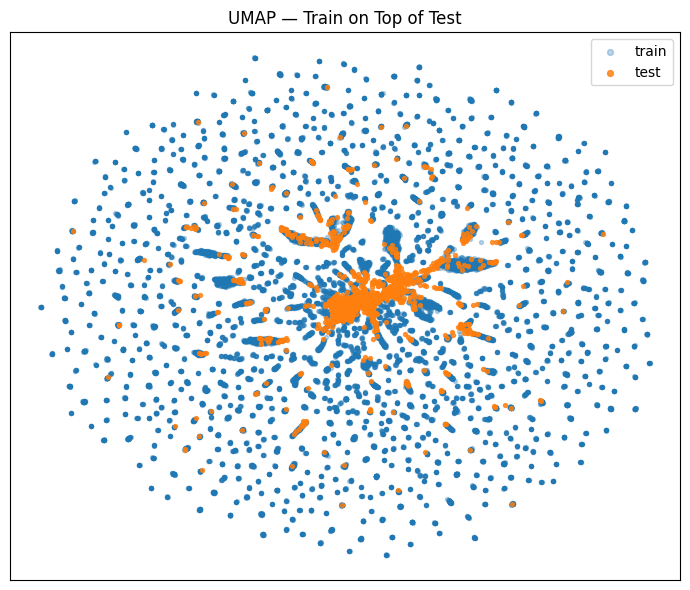

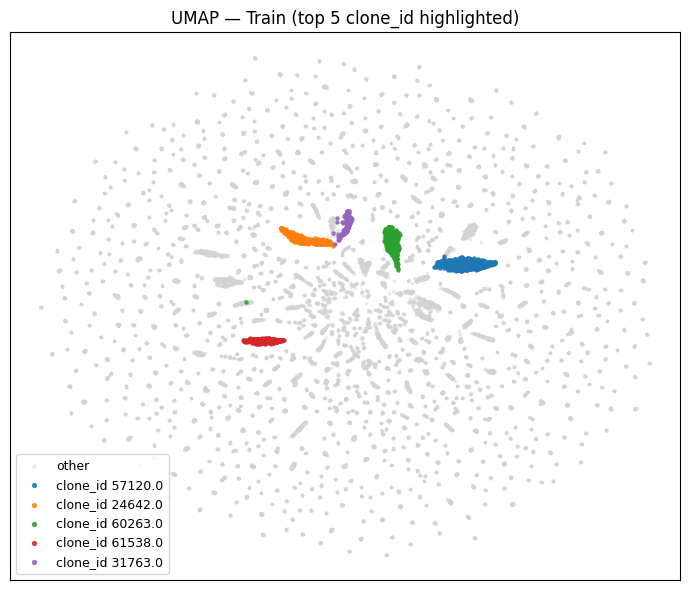

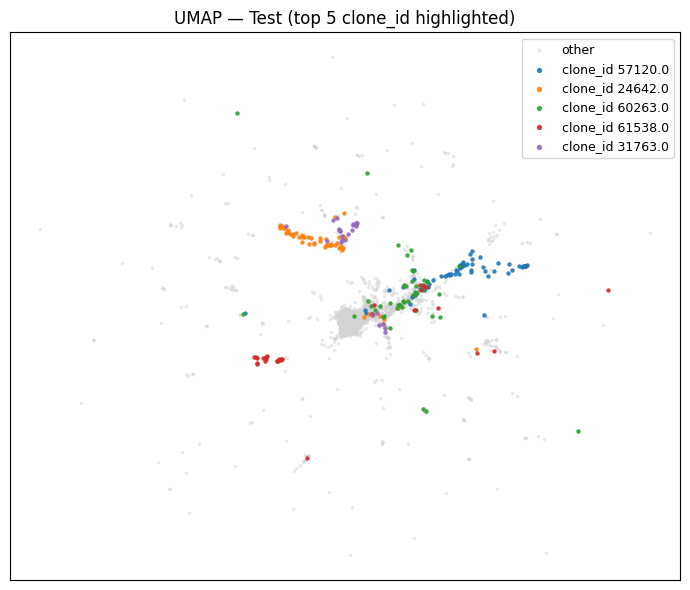

In [9]:
plot_train_test_umap(emb2d_train_001_5, emb2d_test_001_5)
plot_top5_umap(emb2d_train_001_5, adata_Cell_Multi_labels, title="UMAP — Train (top 5 clone_id highlighted)")
plot_top5_umap(emb2d_test_001_5,  adata_Cell_tag_labels,  title="UMAP — Test (top 5 clone_id highlighted)")

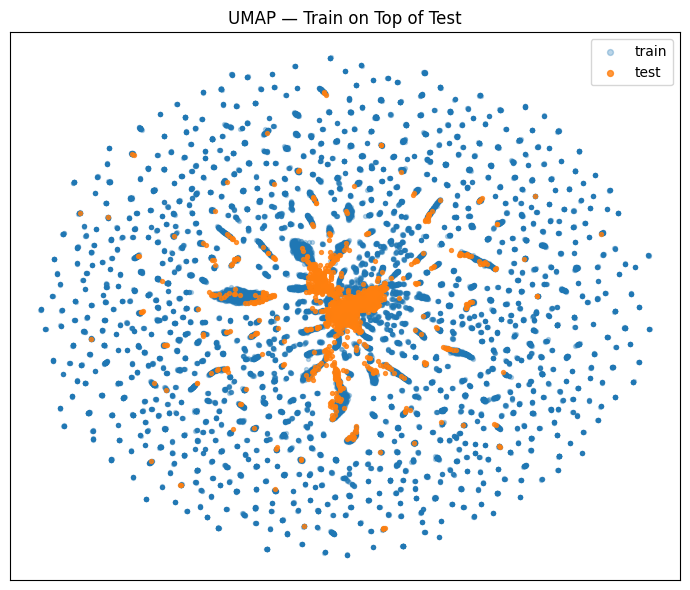

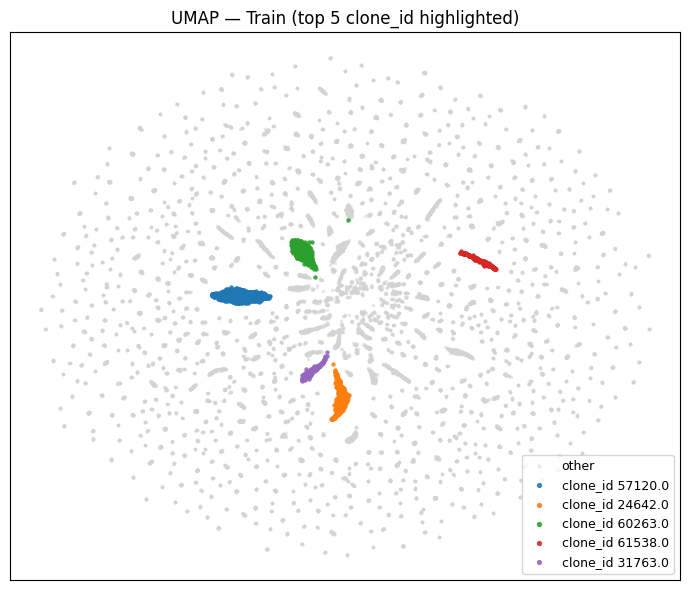

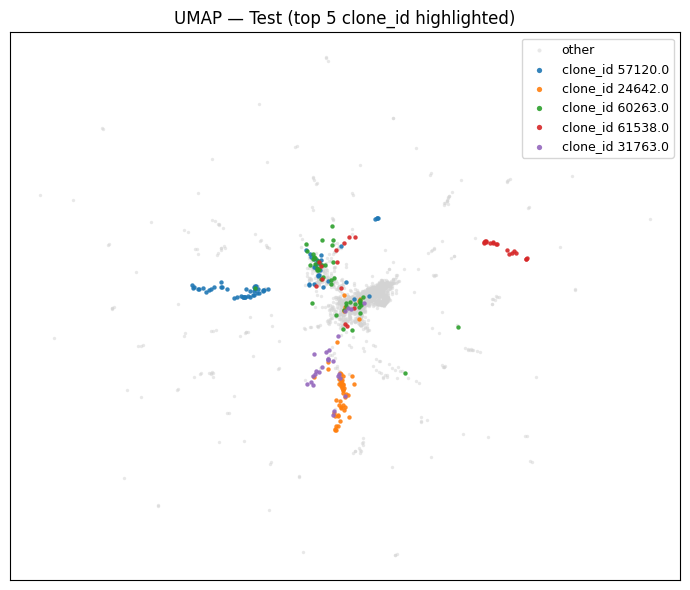

In [10]:
plot_train_test_umap(emb2d_train_001_10, emb2d_test_001_10)
plot_top5_umap(emb2d_train_001_15, adata_Cell_Multi_labels, title="UMAP — Train (top 5 clone_id highlighted)")
plot_top5_umap(emb2d_test_001_15,  adata_Cell_tag_labels,  title="UMAP — Test (top 5 clone_id highlighted)")

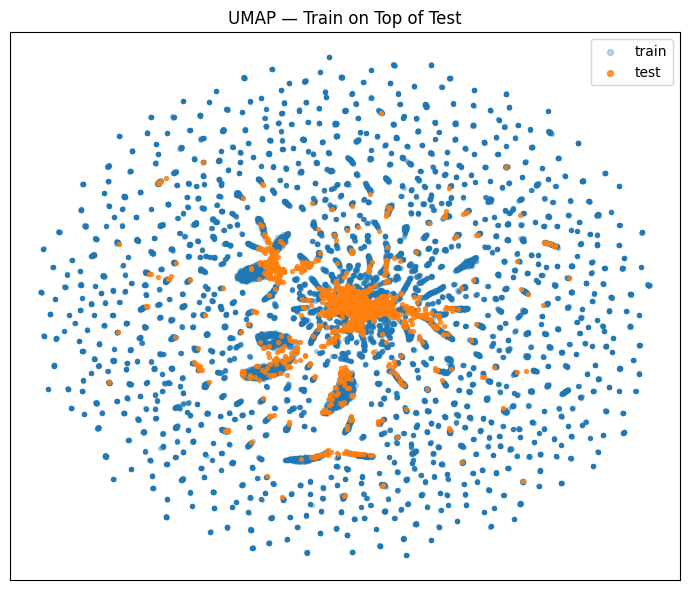

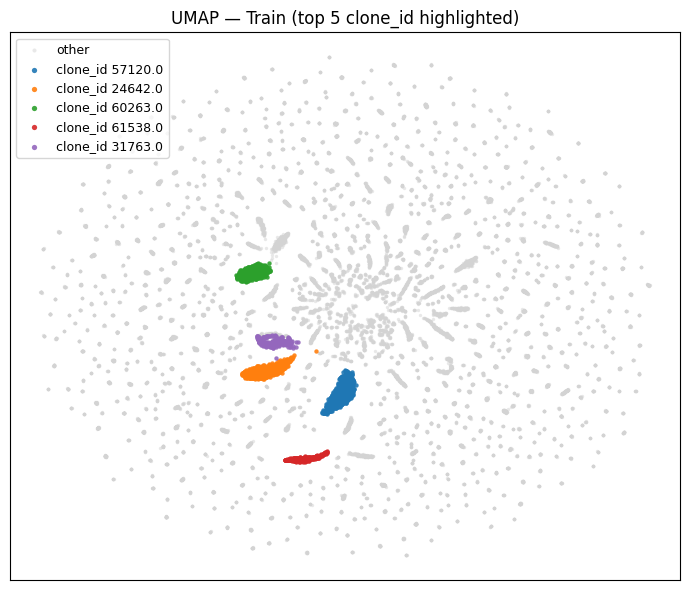

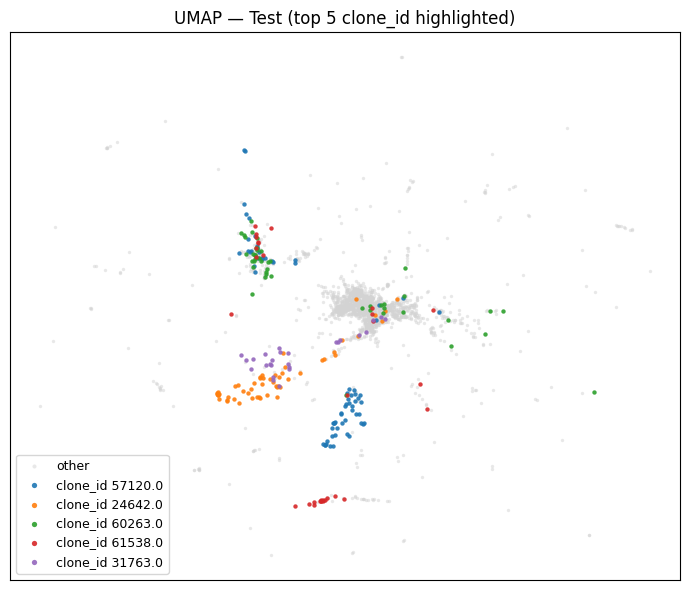

In [11]:
plot_train_test_umap(emb2d_train_001_25, emb2d_test_001_25)
plot_top5_umap(emb2d_train_001_25, adata_Cell_Multi_labels, title="UMAP — Train (top 5 clone_id highlighted)")
plot_top5_umap(emb2d_test_001_25,  adata_Cell_tag_labels,  title="UMAP — Test (top 5 clone_id highlighted)")